In [1]:
### Importing all the neccessary packages ###
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
from scipy.stats import circmean
from scipy import optimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
#import intake
import pathlib

import seasonality.seasonalityfunctions as sf

In [ ]:
### Bombardi et al., 2019 has put the code on github under the MIT license, which allows us to utilize their code in any way we see fit. 
### We will of course credit Bombardi et al., 2019 in the eventual manuscript.

In [138]:
### Allows us to use dask to speed up some calculations ###
from dask.distributed import Client
client = Client()


In [139]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63665,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:63679,Total threads: 2
Dashboard: http://127.0.0.1:63681/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:63668,


In [137]:
catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
col = intake.open_esm_datastore(catalog_url)
col

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


In [141]:
col_subset = col.search(frequency=["daily"], component="atm", variable="PRECT",
                        experiment=["20C", "RCP85", "HIST"])

In [142]:
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/var/folders/m4/3slgbrxj3z3dm65l82539j6w0000gq/T/ipykernel_15643/234168810.py:1: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})



Dataset dictionary keys:
 dict_keys(['atm.HIST.daily', 'atm.20C.daily', 'atm.RCP85.daily'])


In [143]:
ds_HIST = dsets['atm.HIST.daily']['PRECT']
ds_20C = dsets['atm.20C.daily']['PRECT']
ds_RCP85 = dsets['atm.RCP85.daily']['PRECT']


In [147]:
test = ds_20C.sel(lat=46,lon=-105+360,member_id=105, method="nearest").compute()

In [149]:
test.to_netcdf("test_cesm.nc")

In [23]:
### Peru Domain ###
min_lon = -83+360
min_lat = -18.0
max_lon = -67+360
max_lat = 0.0


subset20C = ds_20C.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
subsetRCP85 = ds_RCP85.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
subsetHIST = ds_HIST.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))


In [24]:
cropped_ds

<xarray.DataArray 'PRECT' (member_id: 40, time: 31390, lat: 19, lon: 13)>
dask.array<getitem, shape=(40, 31390, 19, 13), dtype=float32, chunksize=(1, 576, 19, 13), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -17.43 -16.49 -15.55 ... -2.356 -1.414 -0.4712
  * lon        (lon) float64 277.5 278.8 280.0 281.2 ... 288.8 290.0 291.2 292.5
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    units:         m/s

In [ ]:
### Data Directory For Narwhal ###
data_dir = '/data/deluge/reanalysis/REANALYSIS/ERA5/2D/daily/precip/'

In [ ]:
### Opening all of the ERA5 daily precipitation data. The 'time':-1 section loads the data such that each 'chunk' has the entire time series, but is only 100x100 lat, lon.
ds = xr.open_mfdataset(data_dir+'*.nc',parallel=True, chunks={'latitude': 25, 'longitude': 25, 'time': -1})


In [ ]:
### subsetting the data so we grab only north america.
subset=ds.sel(latitude=slice(50,30), longitude=slice((360.0-125),(360.0-65.0)))


In [ ]:
### Showing the advantage of using Dask to perform operations ###
### Time without dask:  319 seconds.  
### Time with dask: 155 seconds.


start = time.time()



ds_subset = subset.load()
end = time.time()
print(end - start)


In [2]:
test = xr.open_dataset("test_cesm.nc")

In [3]:
dr = pd.date_range('1920-01-01','2005-12-31', freq='1D')
dates_noleap = dr[(dr.day != 29) | (dr.month != 2)]
test['time'] = dates_noleap

In [4]:
# Renaming datarray to match existing code and changeing from m/s to m
ds_subset = test.rename({'PRECT':'precip'})*86400.0

In [5]:
### Changing data to mm and removing leap days ###
precip = ds_subset['precip']*1000.0
precip = precip.sel(time=~((precip.time.dt.month == 2) & (precip.time.dt.day == 29)))

### Calculating the mean precipitation for each grid point
annual_mean_precip = precip.mean(dim='time')

### Calculating the mean annual cycle ###
annual_precip_cycle= precip.groupby('time.dayofyear').mean(dim='time')

# Pandas creates leap day again with dayofyear use here
annual_precip_cycle = annual_precip_cycle[annual_precip_cycle.dayofyear != 60]
annual_precip_cycle['dayofyear'] = np.arange(1,365+1,1)

annual_precip_cycle_var = precip.groupby('time.dayofyear').std(dim='time')

# Pandas creates leap day again with dayofyear use here
annual_precip_cycle_var = annual_precip_cycle_var[annual_precip_cycle_var.dayofyear != 60]
annual_precip_cycle_var['dayofyear'] = np.arange(1,365+1,1)

### Create Daily precip from hourly ###
##daily_precip = precip.resample(time='1D').sum()

### Create The annual daily precip anomalies ###
annual_means = precip.groupby('time.year').mean(dim='time')


anomalies = precip.groupby('time.year') - annual_means
#anomalies = anomalies_withleap.sel(time=~((anomalies_withleap.time.dt.month == 2) & (anomalies_withleap.time.dt.day == 29)))

climDailyMeanAnomaly = annual_precip_cycle - annual_mean_precip

In [6]:
np.argmin(sf.harmonic_smoothing(annual_precip_cycle, num_harm=1))

354

In [288]:
np.savez_compressed("5th_order_smooth_of_apc",harmonic_smoothing(annual_precip_cycle,num_harm=5))

In [162]:

np.savez_compressed("precip_1d_test_data_mm",precip = precip)

In [163]:
np.load("precip_1d_test_data_mm.npz")['precip']

array([1.0268236 , 0.07144659, 0.05566972, ..., 1.2683742 , 1.7193818 ,
       0.985238  ], dtype=float32)

In [164]:
precip

<xarray.DataArray 'precip' (time: 31390)>
array([1.0268236 , 0.07144659, 0.05566972, ..., 1.2683742 , 1.7193818 ,
       0.985238  ], dtype=float32)
Coordinates:
    lat        float64 45.71
    lon        float64 255.0
    member_id  int64 105
  * time       (time) datetime64[ns] 1920-01-01 1920-01-02 ... 2005-12-31

In [19]:
### Use dask to run the Harmonics finction over the data ### 
# Slightly faster than a loop but still slow ###

start_wet3 = xr.apply_ufunc(
    sf.start_wet,
    annual_precip_cycle,
    input_core_dims=[["dayofyear"]],
    exclude_dims=set(["dayofyear"]),
    vectorize=True,
    dask='parallized',
    output_dtypes=[annual_precip_cycle.dtype]
)


In [20]:
start_wet3

<xarray.DataArray 'precip' ()>
array(354., dtype=float32)
Coordinates:
    lat        float64 ...
    lon        float64 ...
    member_id  int64 ...

In [22]:
array_jday = anomalies.time.dt.dayofyear
input_data = anomalies.assign_coords(jday=("time",array_jday.data))

In [48]:
2006 - 1920

86

In [140]:
years_ = np.unique(anomalies.time.dt.year.values)

In [37]:
time_onset = np.array(pd.DatetimeIndex(input_data.time).dayofyear)
time_onset

array([  1,   2,   3, ..., 363, 364, 365])

In [90]:
test_index = np.array(pd.DatetimeIndex(input_data.time).year)

In [97]:
data = input_data.values

In [98]:
data

array([-0.7469406 , -1.7023177 , -1.7180946 , ..., -0.41036248,
        0.04064512, -0.6934987 ], dtype=float32)

In [139]:
test_onset_output = onset_LM01(data,time_onset,test_index, 354)

In [152]:
onset_date = np.array([pd.to_datetime(i, format='%Y') + pd.Timedelta(k, unit='D') for i,k in zip(years_,test_onset_output)])

In [157]:
onset_date[5]

Timestamp('1925-03-16 00:00:00')

In [155]:
precip.sel(time=onset_date[5])

<xarray.DataArray 'precip' ()>
array(12.611167, dtype=float32)
Coordinates:
    lat        float64 45.71
    lon        float64 255.0
    member_id  int64 105
    time       datetime64[ns] 1925-03-16

In [137]:
def onset_LM01(data, days, years, startWet):
    
    if len(days) != len(years):
        raise ValueError('Length of days and years must be the same.')
        
    # Want to make sure we get all the input years before any trimming
    unique_years = np.unique(years)
    
    onsetDOY = np.empty((len(unique_years)))
    onsetDOY[:] = np.nan
    


    # Day of year is missing integer 60 which is February 29th.
    # Need to add zero because a tuple is returned from np.where
    temp_start_index = np.where(days == startWet)[0]
    
    # double check we have enough data for last onset calculation
    if len(days[temp_start_index[-1]:]) < 180:
        
        # trim off data we can't use
        data_trimmed = data[temp_start_index[0]:temp_start_index[-1]]
        days_trimmed = days[temp_start_index[0]:temp_start_index[-1]]
        years_trimmed = years[temp_start_index[0]:temp_start_index[-1]]
        
    # Reindex start days with trimmed days  
    # Need to add zero because a tuple is returned from np.where
    start_day_index = np.where(days_trimmed == startWet)[0]
    
    ### looping through start dates ###
    for start_day in start_day_index:
        
        # Make analysis period 180 days in length. 
        #TODO #check that 180 days matters
        analysis_begin = start_day
        analysis_end = start_day + 180
        
        analysis_days = days_trimmed[analysis_begin:analysis_end]
        analysis_years = years_trimmed[analysis_begin:analysis_end]
        
        cumsum_data = np.cumsum(data_trimmed[analysis_begin:analysis_end])
        
        # this returns the index of the data not the day
        onset_index = np.argmin(cumsum_data)
        onset_day = analysis_days[onset_index]
        onset_year = analysis_years[onset_index]
        
        where_to_place = np.argwhere(unique_years == onset_year)[0][0]
        onsetDOY[where_to_place] = onset_day
        
    return onsetDOY


In [23]:
### Used for testing individual areas ###
data = input_data.values
data_time = input_data.time.values
data_jday = input_data.jday.values

start_test = start_wet3.values

In [30]:
test_time = pd.DatetimeIndex(data_time)

In [33]:
np.array(test_time.dayofyear[0:62])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63])

In [177]:
onset_date[np.flatnonzero(np.isin(years_,np.array([1960,1961])))]

array([Timestamp('1960-04-13 00:00:00'), Timestamp('1961-05-27 00:00:00')],
      dtype=object)

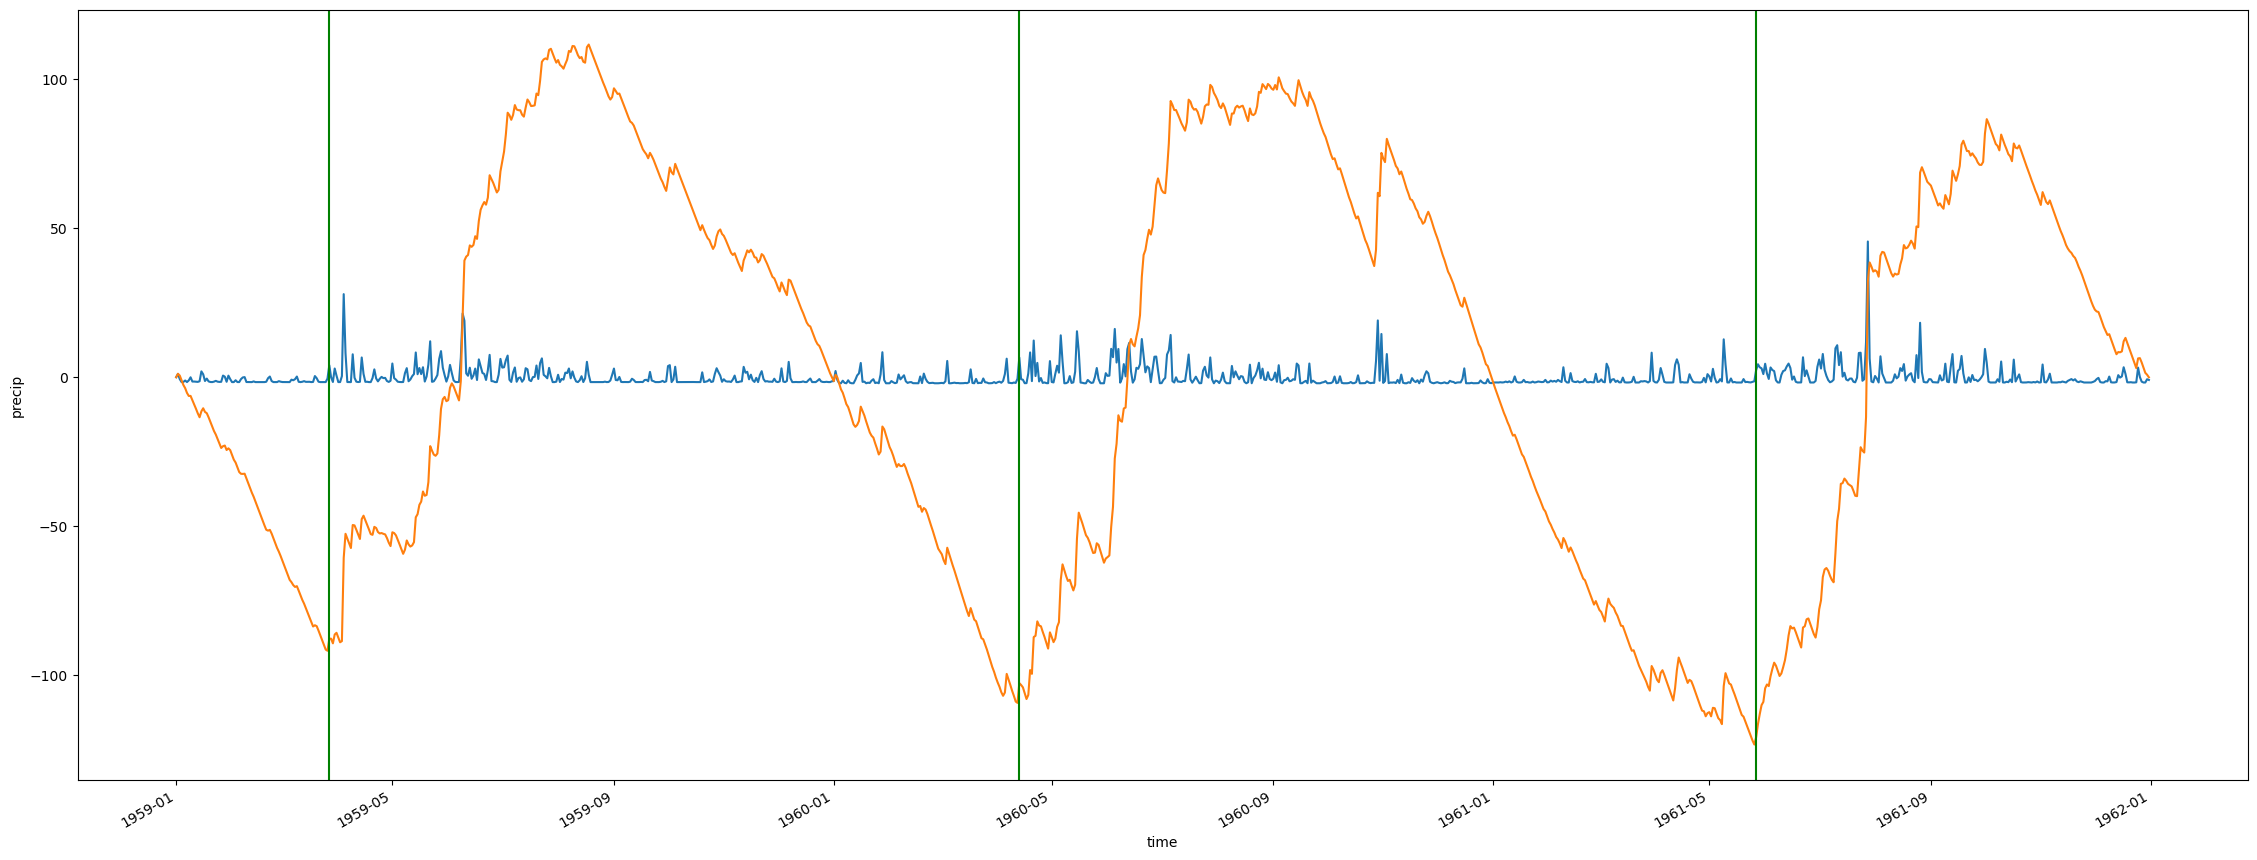

In [183]:
years_to_plot = [1959,1961]
years_slice = slice(str(years_to_plot[0]),str(years_to_plot[1]))
dates_to_plot = onset_date[np.flatnonzero(np.isin(years_,np.arange(years_to_plot[0],years_to_plot[1]+1)))]
input_data.sel(time=years_slice).plot(figsize=(28,10))
input_data.sel(time=years_slice).cumsum().plot()
for i in dates_to_plot:
    plt.axvline(i, color='green') 

In [ ]:
n=0
input_data.sel(latitude=lat, longitude=lon, time=slice(test_onset[:-1][n]-50,test_demise[1:][n]+50)).plot(figsize=(28,10))
plt.axvline(test_onset[:-1][n], color='green')
plt.axvline(test_demise[1:][n],color='brown')

In [24]:
test_onset = onset_LM01(data,data_time,start_test)

In [25]:
test_onset

array(['1921-04-24', '1922-04-11', '1923-05-20', '1924-03-16',
       '1925-03-15', '1926-03-17', '1927-03-19', '1928-03-01',
       '1929-04-30', '1930-04-04', '1931-05-01', '1932-04-06',
       '1933-04-17', '1934-04-13', '1935-06-04', '1936-04-01',
       '1937-03-14', '1938-04-04', '1939-04-19', '1940-03-27',
       '1941-04-25', '1942-05-05', '1943-03-26', '1944-04-24',
       '1945-03-15', '1946-04-30', '1947-03-25', '1948-03-21',
       '1949-04-12', '1950-03-25', '1951-04-16', '1952-03-23',
       '1953-03-19', '1954-05-16', '1955-04-25', '1956-04-05',
       '1957-04-04', '1958-04-27', '1959-03-26', '1960-04-12',
       '1961-05-26', '1962-04-14', '1963-04-10', '1964-03-18',
       '1965-05-06', '1966-04-29', '1967-03-30', '1968-04-10',
       '1969-04-02', '1970-03-13', '1971-03-21', '1972-05-06',
       '1973-04-30', '1974-03-21', '1975-05-05', '1976-03-14',
       '1977-04-23', '1978-05-22', '1979-02-25', '1980-04-08',
       '1981-04-27', '1982-04-01', '1983-03-24', '1984-

In [ ]:
def demise_LM01(data, time, startWet):
    ### Requires anomaly data ###
    dataLength = len(data)
    data_time = pd.DatetimeIndex(time)
    ### dayofyear is 1 indexed.
    if (startWet <= 0):
        startWet=1
    
    startDOY= np.where(data_time.dayofyear == startWet)[0]
    nYears = len(np.unique(data_time.year))
    
    demiseDOY=np.empty((nYears))
    demiseDOY[:] = np.nan
    demiseDate=np.empty((nYears),dtype='datetime64[D]')
    demiseDate[:] = 'nat'
    #print(startWet)
    ### looping through start dates ###
    for i, start in enumerate(startDOY):
        analysisBegin = start
        analysisEnd = start - int(180)
        ### Make sure we dont exceed our data ###
        if analysisBegin < dataLength and analysisEnd > 0:
             ### end of analysis is 180 days later
            ### Make sure that we have enough data to compute ###
            analysisPeriod = data_time[analysisBegin:analysisEnd:-1]
            ### Cumulative Sum ###
            sumSeries = np.cumsum(data[analysisBegin:analysisEnd:-1])
            
            
            demise = np.argmin(sumSeries)
            #print(demise)
            #print(analysisPeriod[demise])
            #print(onset)
            demiseDOY[i] = demise
            demiseDate[i] = analysisPeriod[demise]
            if (analysisBegin > demise > analysisEnd):
                #print(onset)
                demiseDOY[i] = demise
                demiseDate[i] = analysisPeriod[demise]
            #if (i==2):
                #break
    return demiseDate

In [ ]:
def onset_bombardi(data, data_time, startWet):
    #print(f"data: {data.shape} | time: {data_time.shape} | start_test: {start_test.shape}")
    ### Precalculations ###
    if (startWet <= 0):
        startWet=1
    sseries=np.zeros((int(366/2)))
    dataLength = len(data)
    data_time = pd.DatetimeIndex(data_time)
    startDOY= np.where(data_time.dayofyear == startWet)[0]
    #print(len(np.unique(startDOY)))
    nyrs = len(np.unique(data_time.year))
    ytot=365
    ### Data Structures to hold results ###
    sjday=np.empty((nyrs))
    sjday[:] = np.nan
    sdate=np.empty((nyrs),dtype='datetime64[D]')
    sdate[:] = 'nat'
    #smonth=np.zeros((nyrs))
    #syear=np.zeros((nyrs))
    ### Run through entire time series for one grid point ###
    yt = -1
    for i, start in enumerate(startDOY):
        ### Loop through the list of start days ###
        if start < (dataLength):         # -5 to avoid calcualtion with short time series for last year
            
            beg = start
            end = beg+int(365/2)
            if end <= dataLength-1:  # it is not the last year
                end2=int(ytot/2)
            if end > dataLength-1:
                end=dataLength-1
                end2=end-beg
            sseries[:]=0
            sseries[0:end2]=np.cumsum(data[beg:beg+end2])
            #curve[yt,:]=sseries[:]
            #-------------------------------------------------------------------------
            # Calculating onset and demise of the rainy season
            #-------------------------------------------------------------------------
            beg=0
            try:
                ons=np.where(sseries[0:end2] == sseries[0:end2].min())
            except ValueError:
                pass
                #print(beg)
            if len(ons[0]) > 0:
                
                beg=ons[0][0]+start+1
                #print(beg)
            if beg > 0 and beg < end:

                sjday[yt]= data_time[beg].dayofyear
                sdate[yt]= data_time[beg]
                #smonth[yt]= data_time[beg].month
                #syear[yt]= data_time[beg].day
    return sdate





#========================================================================
#                             End of subroutine
#========================================================================

In [ ]:
def demise_calculation(data, data_time, startWet):
 ### Reverse Date for Demise Calculation
    data = data[::-1]
    data_time = data_time[::-1]
    ### Precalculations ###
    if (startWet <= 0):
        startWet=1
    sseries=np.zeros((int(366/2)))
    dataLength= len(data)
    yt=-1
    data_time = pd.DatetimeIndex(data_time)
    start_list = np.where(data_time.dayofyear == startWet)[0]
    #print(start_test)
    nyrs = len(np.unique(data_time.year))
    ytot=365
    ### Data Structures to hold results ###
    sjday=np.empty((nyrs))
    sjday[:] = np.nan
    sdate=np.empty((nyrs),dtype='datetime64[D]')
    sdate[:] = 'nat'
    #smonth=np.zeros((nyrs))
    #syear=np.zeros((nyrs))
    ### Run through entire time series for one grid point ###
    for start in start_list:
        #print(start)
        #    for tt in range(0,dataLength-5): # -5 to avoid calcualtion with short time series for last year
        #------------------------------------------------------------------------
        # Starting the calculation of accumulated anomalies in the rainy season
        #------------------------------------------------------------------------                 !
        #        if jday[tt] == jstart:
        if start < (dataLength):         # -5 to avoid calcualtion with short time series for last year
            yt=yt+1
            beg= start
            end = beg+int(365/2)
            if end <= dataLength-1:  # it is not the last year
                end2=int(ytot/2)
            if end > dataLength-1:
                end=dataLength-1
                end2=end-beg
            sseries[:]=0
            sseries[0:end2]=np.cumsum(data[beg:beg+end2])
            #curve[yt,:]=sseries[:]
            #-------------------------------------------------------------------------
            # Calculating onset and demise of the rainy season
            #-------------------------------------------------------------------------
            beg=0
            try:
                ons=np.where(sseries[0:end2] == sseries[0:end2].min())
            except ValueError:
                #print(beg)
                pass
            if len(ons[0]) > 0:
                beg=ons[0][0]+start+1
                #print(beg)
            if beg > 0 and beg < end:

                sjday[yt]= data_time[beg].dayofyear
                sdate[yt]= data_time[beg]
                #smonth[yt]= data_time[beg].month
                #syear[yt]= data_time[beg].day
    return sdate[::-1]





In [ ]:
### 500 seconds ###

### 423 without Dask... Need more optimization... ###
start = time.time()
"the code you want to test stays here"




demise_LM01_test = xr.apply_ufunc(
    demise_LM01,
    anomalies,
    anomalies.time,
    start_wet2,
    input_core_dims=[["time"],["time"],[]],
    exclude_dims=set(["time"]),
    output_core_dims=[["year"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)
end = time.time()
print(end - start)

In [ ]:
### 500 Seconds ###
start = time.time()
"the code you want to test stays here"




onset_LM01_test = xr.apply_ufunc(
    onset_LM01,
    anomalies,
    anomalies.time,
    start_wet2,
    input_core_dims=[["time"],["time"],[]],
    exclude_dims=set(["time"]),
    output_core_dims=[["year"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)
end = time.time()
print(end - start)

In [ ]:
### 500 Seconds ###
start = time.time()
"the code you want to test stays here"




onset_bombardi_test = xr.apply_ufunc(
    onset_bombardi,
    anomalies,
    anomalies.time,
    start_wet2,
    input_core_dims=[["time"],["time"],[]],
    exclude_dims=set(["time"]),
    output_core_dims=[["year"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)
end = time.time()
print(end - start)

In [ ]:
### 500 Seconds ###
start = time.time()
"the code you want to test stays here"




demise_bombardi_test = xr.apply_ufunc(
    demise_calculation,
    anomalies,
    anomalies.time,
    start_wet2,
    input_core_dims=[["time"],["time"],[]],
    exclude_dims=set(["time"]),
    output_core_dims=[["year"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)
end = time.time()
print(end - start)

In [ ]:
onset_data = onset_LM01_test
demise_data = demise_LM01_test
onset_data.name = 'onset_date'
demise_data.name = 'demise_date'
onset_data.coords['year'] = pd.date_range("1951", periods=70, freq='YS')
demise_data.coords['year'] = pd.date_range("1951", periods=70, freq='YS')

In [ ]:
onset_data.isel(latitude = 20, longitude = 30)

In [ ]:
test_onset = xr.merge([onset_data,demise_data])

In [ ]:
onset_LM01_test.isel(latitude = 20, longitude = 30)[:-1] - demise_LM01_test.isel(latitude = 20, longitude = 30)[1:] 

In [ ]:
onset_LM01_test = onset_LM01_test.isel(year=slice(0,70))

In [ ]:
demise_LM01_test = demise_LM01_test.isel(year=slice(1,71))

In [ ]:
test_onset['demise_doy'] = test_onset['demise_date'].dt.dayofyear
test_onset['onset_doy'] = test_onset['onset_date'].dt.dayofyear

In [ ]:
test_onset.to_netcdf('OnsetDemise_ERA5.nc')

In [ ]:
test_onset['onset_doy'].sel(year='2011').plot()

In [ ]:
demise.to_netcdf('wetseason.demise.era5.nc')

In [ ]:
onset.to_netcdf('wetseason.onset.era5.nc')

In [ ]:
(test_mean - demise['demise_date'].mean(dim='year')).plot()

In [ ]:
## TODO: Need to reverse the output array ###

demise['demise_date'].mean(dim='year').plot(figsize=(13,8))

In [ ]:
test6['onset_date'].mean(dim='data_jday').plot(figsize=(13,8))

In [ ]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#cmap = mpl.cm.RdBu_r


f, ax1 = plt.subplots(1, 1, figsize=(10, 13), dpi=600, subplot_kw={'projection': map_proj})
p = onset_data.dt.dayofyear.isel(year=50).plot.pcolormesh(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='viridis')


### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='black')
ax1.add_feature(cfeature.STATES, edgecolor='black')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)